# ***1- Olive Detection - Classification 2***

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***1-1. Import Required Libraries***

In [2]:
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense, Convolution2D, MaxPool2D, Activation, Dropout, Flatten, Input, Add, ZeroPadding2D, BatchNormalization, Conv2D, AveragePooling2D
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator

***1-2. Test/Train Data***

In [3]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count = 0
  # crawls inside folders
  for current_path, dirs, files in os.walk(directory):
    for dr in dirs:
      count += len(glob.glob(os.path.join(current_path, dr+"/*")))
  return count
train_dir = "/content/drive/MyDrive/OliveDataset/train"
test_dir  = "/content/drive/MyDrive/OliveDataset/test"

In [4]:
from keras.utils.data_utils import get_file
# train file image count
train_samples = get_files(train_dir)
# to get tags
num_classes = len(glob.glob(train_dir+"/*"))
# test file image count
test_samples = get_files(test_dir)
print(num_classes, "Classes")
print(train_samples, "Train images")
print(test_samples, "Test images")

3 Classes
2720 Train images
714 Test images


***1-3. ImageDataGenerator***

In [5]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True
)
test_datagen = ImageDataGenerator(
    rescale= 1./255
)

In [6]:
input_shape = (224, 224, 3)
train_generator = train_datagen.flow_from_directory(train_dir, target_size= (224, 224), batch_size= 32)
test_generator = test_datagen.flow_from_directory(test_dir,shuffle= True, target_size= (224, 224), batch_size= 32)

Found 2720 images belonging to 3 classes.
Found 714 images belonging to 3 classes.


***1-4. VGG19 Model***

In [7]:
def create_Base_model_from_VGG19():  
    model_vgg19 = VGG19(
        weights = "imagenet",# control point from which model is started
        include_top=False, # to include/exclude the first 3 layers
        input_shape = (224,224, 3)) # image size
    # don't train existing weights 
    for layer in model_vgg19.layers:
      layer.trainable = False
    return model_vgg19 
create_Base_model_from_VGG19().summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [8]:
def add_custom_layers_vgg19():
    #Adding custom Layers 
    model_vgg19 = create_Base_model_from_VGG19()
    x = model_vgg19.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)   
    # creating the final model 
    final_model = tf.keras.models.Model(
        inputs = model_vgg19.input, 
        outputs = predictions)
     
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  
    return final_model

add_custom_layers_vgg19().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 714 images belonging to 3 classes.


In [11]:
model_from_vgg19 = add_custom_layers_vgg19()
history3 = model_from_vgg19.fit(train_generator,
                      steps_per_epoch=None,
                      epochs=6,
                      validation_data=validation_generator,
                      validation_steps=None,
                      verbose=1,
                      callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
                      use_multiprocessing=False,
                      shuffle=True)

Epoch 1/6
85/85 [==============================] - 954s 11s/step - loss: 1.2750 - accuracy: 0.5934 - val_loss: 0.7554 - val_accuracy: 0.6401 - lr: 0.0010
Epoch 2/6
85/85 [==============================] - 81s 955ms/step - loss: 0.5755 - accuracy: 0.7676 - val_loss: 0.6373 - val_accuracy: 0.7311 - lr: 0.0010
Epoch 3/6
85/85 [==============================] - 81s 955ms/step - loss: 0.4553 - accuracy: 0.8210 - val_loss: 0.6775 - val_accuracy: 0.7059 - lr: 0.0010
Epoch 4/6
85/85 [==============================] - 83s 978ms/step - loss: 0.4434 - accuracy: 0.8184 - val_loss: 0.5653 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 5/6
85/85 [==============================] - 84s 992ms/step - loss: 0.4109 - accuracy: 0.8371 - val_loss: 1.1638 - val_accuracy: 0.5868 - lr: 0.0010
Epoch 6/6
85/85 [==============================] - 84s 986ms/step - loss: 0.3944 - accuracy: 0.8386 - val_loss: 0.5335 - val_accuracy: 0.8095 - lr: 0.0010


In [12]:
model_from_vgg19.save('/content/drive/MyDrive/Colab Notebooks/models_olive/model_cl2_vgg19.h5')

In [13]:
print("[INFO] Calculating model accuracy")
scores = model_from_vgg19.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
23/23 [==============================] - 17s 732ms/step - loss: 0.5249 - accuracy: 0.7969
Test Accuracy: 79.69187498092651


In [14]:
results = model_from_vgg19.evaluate(test_generator, verbose=1)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

23/23 [==============================] - 9s 382ms/step - loss: 0.5139 - accuracy: 0.7983
Test Loss: 0.51386
Test Accuracy: 79.83%


In [15]:
# Predict the label of the test_gen
pred = model_from_vgg19.predict(test_generator,verbose=1)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

23/23 [==============================] - 9s 399ms/step


In [ ]:
# y_test = list(train_generator.Label)
# print(classification_report(y_test, pred))

AttributeError: ignored

# ***2- Model Test***

***2-2. VGG19 Model***

In [16]:
# load model vgg19
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_vgg19 = load_model('/content/drive/MyDrive/Colab Notebooks/models_olive/model_cl2_vgg19.h5')

olive_peacock_spot


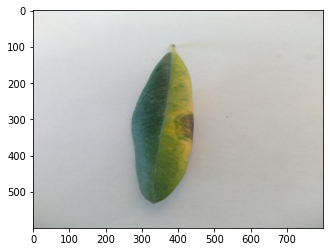

In [17]:
classes_vgg19 = list(train_generator.class_indices.keys())
# Pre-Processing test data same as train data.
def prepare(img_path):
  img = image.load_img(img_path, target_size = (224, 224))
  x = image.img_to_array(img)
  x = x/255
  return np.expand_dims(x, axis=0)

img_url = '/content/drive/MyDrive/dataset_olive/test/Olive/IMG_20190806_165500.jpg'
result_vgg19 = model_vgg19.predict([prepare(img_url)])
img_pred_vgg19 = image.load_img(img_url)
plt.imshow(img_pred_vgg19)

classresult_vgg19 = np.argmax(result_vgg19, axis=1)
print(classes_vgg19[classresult_vgg19[0]])